In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 2.8MB/s 
     |████████████████████████████████| 194kB 14.4MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 1.1MB 14.3MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 92kB 9.2MB/s 
     |████████████████████████████████| 40kB 5.6MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 61kB 7.9MB/s 
     |████████████████████████████████| 2.6MB 21.9MB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from IPython.display import display, HTML

In [3]:
# workingon the Siamese pair,
# takes two images to say if they belong to same class or not

from fastai.vision.all import *
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

If we didn't care about showing our objects at all, we could directly create one transform to completely preprocess that list of files. We will want to look at those images though, so we need to create a custom type. When you call the show method on a TfmdLists or a Datasets object, it will decode items until it reaches a type that contains a show method and use it to show the object. That show method gets passed a ctx, which could be a matplotlib axis for images, or a row of a DataFrame for texts.

Here we create a SiameseImage object that subclasses fastuple and is intended to contain three things: two images, and a Boolean that's True if the images are of the same breed. We also implement the special show method, such that it concatenates the two images with a black line in the middle. Don't worry too much about the part that is in the if test (which is to show the SiameseImage when the images are Python images, not tensors); the important part is in the last three lines:

In [6]:
class SiameseImage(fastuple):
  def show(self, ctx=None, **kwargs):
    img1,img2, same_breed = self
    if not isinstance(img1, Tensor):
      if img2.size != img1.size:
        img2 = img2.resize(img1.size)
      t1,t2 = tensor(img1), tensor(img2)
      t1,t2 = t1.permute(2,0,1), t2.permute(2,0,1)
    else:
      t1,t2 = img1,img2
    line = t1.new_zeros(t1.shape[0],t1.shape[1],10)
    return show_image(torch.cat([t1,line, t2], dim=2), title=same_breed, ctx=ctx)

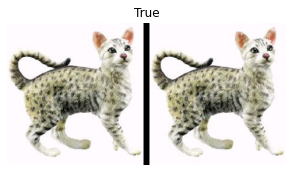

In [7]:
img = PILImage.create(files[0])
s = SiameseImage(img, img, True)
s.show()

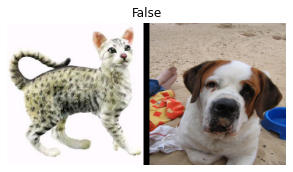

In [8]:
img1 = PILImage.create(files[1])
s1 = SiameseImage(img, img1, False)
s1.show()

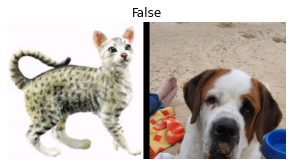

In [9]:
s2 = Resize(224)(s1)
s2.show()

In [10]:
def label_func(fname):
  return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

For each image our tranform will, with a probability of 0.5, draw an image from the same class and return a `SiameseImage` with a true label, or draw an image from another class and return a `SiameseImage` with a false label. This is all done in the private `_draw` function. There is one difference between the training and validation sets, which is why the transform needs to be initialized with the splits: on the training set we will make that random pick each time we read an image, whereas on the validation set we make this random pick once and for all at initialization. This way, we get more varied samples during training, but always the same validation set:

In [11]:
class SiameseTransform(Transform):
  def __init__(self, files, label_func, splits):
    self.labels = files.map(label_func).unique()
    self.lbl2files = {l: L(f for f in files if label_func(f) == l) for l in self.labels}
    self.label_func = label_func
    self.valid = {f: self._draw(f) for f in files[splits[1]]}
  
  def encodes(self, f):
    f2, t = self.valid.get(f, self._draw(f))
    img1,img2 = PILImage.create(f), PILImage.create(f2)
    return SiameseImage(img1, img2, t)
  
  def _draw(self, f):
    same = random.random() < 0.5
    cls = self.label_func(f)
    if not same:
      cls = random.choice(L(l for l in self.labels if l != cls))
    return random.choice(self.lbl2files[cls]),same

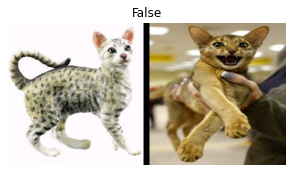

In [12]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, label_func, splits)
tfm(files[0]).show()

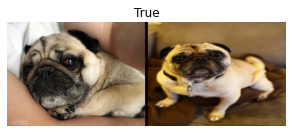

In [13]:
tls = TfmdLists(files, tfm,splits=splits)
show_at(tls.valid, 0)

In [14]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor],
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [18]:
dls.show(0)

We can now train a model using this `DataLoaders`. It will need a bit more customization than the usual model provided by `cnn_learner` since it has to take two images instead of one, but we will see how to create such a model and train it in <<chapter_arch_dtails>>.